In [1]:
import numpy as np

from scipy.io import loadmat
import h5py

import sys, os

import time

import cfl
from bart import bart

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

/packages/development/anaconda/3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_patterns(matrix, shifts,rows=8):
    n_patterns = len(matrix)
    R = matrix.shape[1]
    k = int(n_patterns/rows)+((n_patterns%rows)>0)
    s = np.array(shifts)+1
    plt.figure(figsize=(16,8))
    for i in np.arange(n_patterns):
        plt.subplot(k,rows,s[i])
        plt.imshow(matrix[i])
        plt.title('$\Delta=$ {}'.format(shifts[i]))
        ax = plt.gca();

        # Major ticks
        ax.set_xticks(np.arange(0, R, 1));
        ax.set_yticks(np.arange(0, R, 1));

        # Labels for major ticks
        ax.set_xticklabels(np.arange(1, R+1, 1));
        ax.set_yticklabels(np.arange(1, R+1, 1));

        # Minor ticks
        ax.set_xticks(np.arange(-.5, R, 1), minor=True);
        ax.set_yticks(np.arange(-.5, R, 1), minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)


In [3]:
def caipi(r,ry,shifts):
    """Generates Caipirinha binary unit cells on sheared grids that form periodic lattices
    
    Parameters:
        r (int): total acceleration factor
        ry (int): acceleration factor in the y-direction
        shifts (list), (numpy array): size of shifts in the z-direction
    
    Returns:
        3D numpy array [shifts, ry, rz] containing the patterns
        
    
    """
    rz = int(r/ry)
    patterns = np.zeros((len(shifts),r,r))
    l = 0
    for i, shift in enumerate(shifts):
        cell = np.zeros((r,r))
        for row in range(rz):
            if (shift*row+rz)>= r:
                l = (shift*row%r+rz)%rz
            else:
                l = shift*row
            cell[row*ry,l::rz]=1
        patterns[i] = np.copy(cell)
    return patterns

In [4]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

In [5]:
os.listdir()

['gfactor-demo-synthetic_data.ipynb',
 'h5_radial_file_IO_python.py',
 'cfl.py',
 'h5_radial_file_IO_matlab.m',
 'raw_001_full.mat',
 'rawdata_heart_radial_55proj_34ch.h5',
 'bartview.py',
 'phantom3d_kspace.npy',
 'ReconDevelopment.ipynb',
 '.ipynb_checkpoints',
 'data.h5',
 'gfactor-demo-real_data.ipynb',
 '__pycache__',
 'bart_caipi_nikos_full_mat.ipynb',
 'pos1_epi80.mat',
 'bartview3.py',
 'rawdata_brain_radial_96proj_12ch.h5',
 'gfactor-demo-synthetic_data-CAIPIRINHA-patterns.ipynb',
 'bart.py']

In [16]:
file= h5py.File('raw_001_full.mat', 'r')
for i in file.keys():
    print(i)
    

#refs#
alldata
kspace_properties


In [17]:
#file=read_matlab('raw_001_full.mat')

In [18]:
file.keys()

dict_keys(['#refs#', 'alldata', 'kspace_properties'])

In [32]:
data=np.copy(file['alldata'])

In [33]:
data.shape

(32, 116, 108, 106)

In [34]:
type(data)

numpy.ndarray

In [35]:
plt.imshow(abs(data[0,0]))

TypeError: ufunc 'absolute' did not contain a loop with signature matching types dtype([('real', '<f8'), ('imag', '<f8')]) dtype([('real', '<f8'), ('imag', '<f8')])

In [ ]:
data[0,0].shape

In [39]:
data[0,0]

array([[(0., 0.), (0., 0.), (0., 0.), ..., (0., 0.), (0., 0.), (0., 0.)],
       [(0., 0.), (0., 0.), (0., 0.), ..., (0., 0.), (0., 0.), (0., 0.)],
       [(0., 0.), (0., 0.), (0., 0.), ..., (0., 0.), (0., 0.), (0., 0.)],
       ...,
       [(0., 0.), (0., 0.), (0., 0.), ..., (0., 0.), (0., 0.), (0., 0.)],
       [(0., 0.), (0., 0.), (0., 0.), ..., (0., 0.), (0., 0.), (0., 0.)],
       [(0., 0.), (0., 0.), (0., 0.), ..., (0., 0.), (0., 0.), (0., 0.)]],
      dtype=[('real', '<f8'), ('imag', '<f8')])

In [41]:
data['real'].shape

(32, 116, 108, 106)

In [42]:
data['imag'].shape

(32, 116, 108, 106)

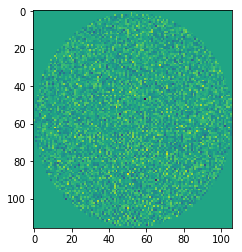

In [49]:
plt.imshow(data['imag'][0,:,10])

In [52]:
np.iscomplex(data['real']).any()

False

In [54]:
datac = data['real']+1j*data['imag']

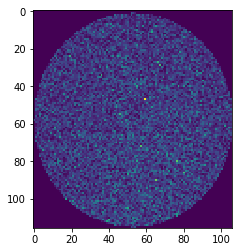

In [63]:
plt.imshow(abs(datac[0,:,10]))

In [79]:
fft = np.fft.ifftn(datac,axes=(1,2,3))

In [95]:
fftsh = np.fft.fftshift(fft)

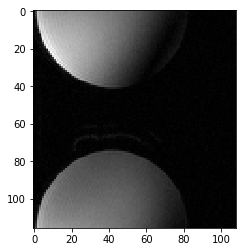

In [100]:
plt.imshow(abs(fftsh[3,:,:,100]),cmap='gray')

In [101]:
fft.shape

(32, 116, 108, 106)

In [102]:
cimg = bart(1,'fft-iu 7',datac)

Exception: Command exited with an error.

In [113]:
print(fft.T.shape)
print(fft.shape)
cimg.shape

(106, 108, 116, 32)
(32, 116, 108, 106)


(106, 108, 116, 32)

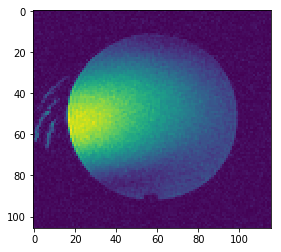

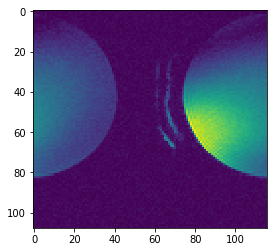

In [116]:
plt.imshow(abs(fft.T[:,100,:,0]))
plt.figure()
plt.imshow(abs(cimg[100,:,:,0]))

In [112]:
#cimg = bart(1,'fft -iu 7',datac.T)

In [148]:
sens = bart(1, 'ecalib -m1', datac.T[:,:,:,:3][:,:,:,:]).squeeze()

In [151]:
sens.shape

(106, 108, 116, 3)

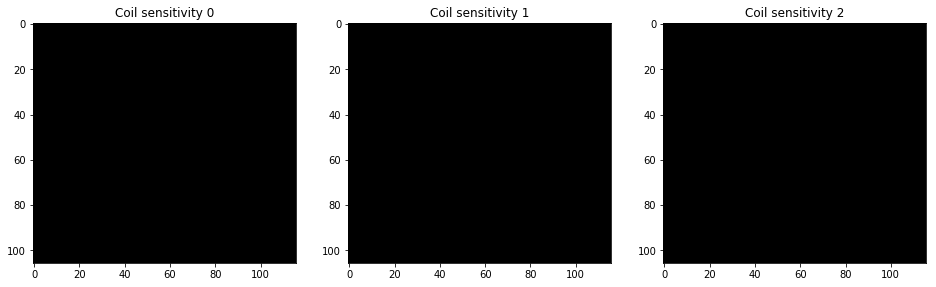

In [150]:
nc = sens.shape[-1]
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,100,:,i]).squeeze(), cmap='gray')
    plt.title('Coil sensitivity {}'.format(i))

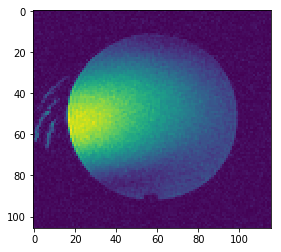

In [127]:
plt.imshow(abs(fft.T[:,100,:,0]))